<a href="https://colab.research.google.com/github/steimel60/ML/blob/main/DeepLearning/DataMunging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.text.all import *

     |████████████████████████████████| 719 kB 4.8 MB/s 
     |████████████████████████████████| 1.2 MB 61.8 MB/s 
     |████████████████████████████████| 346 kB 64.1 MB/s 
     |████████████████████████████████| 4.2 MB 54.0 MB/s 
     |████████████████████████████████| 197 kB 68.0 MB/s 
     |████████████████████████████████| 60 kB 8.4 MB/s 
     |████████████████████████████████| 140 kB 58.8 MB/s 
     |████████████████████████████████| 86 kB 7.5 MB/s 
     |████████████████████████████████| 1.1 MB 53.0 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 
     |████████████████████████████████| 212 kB 56.0 MB/s 
     |████████████████████████████████| 596 kB 58.6 MB/s 
     |████████████████████████████████| 127 kB 49.9 MB/s 
     |████████████████████████████████| 271 kB 66.7 MB/s 
     |████████████████████████████████| 144 kB 68.7 MB/s 
     |████████████████████████████████| 94 kB 4.3 MB/s 
     |████████████████████████████████| 112 kB 73.9 MB/s 
     |█████████████████

In [2]:
#Get text files
path = untar_data(URLs.IMDB)
files = get_text_files(path, folders = ['train', 'test'])
txts = L(o.open().read() for o in files[:2000])
#Tokenize them
tok = Tokenizer.from_folder(path)
tok.setup(txts)
toks = txts.map(tok)
toks[0]

(#445) ['xxbos','*','may','contain','spoilers','*','\n\n','i','bent','over'...]

In [3]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10]

TensorText([   2,  184,  254, 3122,  979,  184,   26,   18, 3663,  142])

##Making your own transforms

In [4]:
#We can make our own transforms and only apply it to specific data types
def f(x:int): return x+1
tfm = Transform(f)
tfm(2), tfm(2.0)

(3, 2.0)

In [5]:
#We can use a decorator to do the above nicer
@Transform
def f(x:int): return x+1
f(2), f(2.0)

(3, 2.0)

In [6]:
#You can also make your own encode/decode methods
class NormalizeMean(Transform):
  def setups(self, items): self.mean = sum(items)/len(items)
  def encodes(self, x): return x-self.mean
  def decodes(self, x): return x+self.mean

tfm = NormalizeMean()
tfm.setup([1,2,3,4,5])
start = 2
y = tfm(start)
z = tfm.decode(y)
tfm.mean,y,z

(3.0, -1.0, 2.0)

##We can use TfmdLists to do all of this at once

In [7]:
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize])
t = tls[0]
t[:20]

TensorText([   2,  232,  226, 2883, 1055,  232,   26,   19, 5721,  143, 5457,   15,   43, 1254,   15,   20,   32,   10,   19,  699])

In [8]:
#And it can stil be decoded
tls.decode(t)[:100]
#And shown
#tls.show(t)

'xxbos * may contain spoilers * \n\n i bent over backwards to be fair to this film . i knew it starred '

In [9]:
#It can also handle train/valid splits
cut = int(len(files)*.8) #Get indice to split at
splits = [list(range(cut)), list(range(cut, len(files)))] #Create indices for each set
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize], splits=splits)
#The splits can be accessed
tls.valid[0][:20]

TensorText([    2,    13,   315,   772,    62,   441,    51,   949,   347,    16,    65,     8,  1776,     0, 39252,  1537,    11,  5605,  4537,    12])

##Computer Vision example

In [10]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

In [11]:
#class to identify if 2 imgs are the same breed
class SiameseImage(fastuple):
  def show(self, ctx=None, **kwargs):
    img1, img2, same_breed = self
    if not isinstance(img1, Tensor):
      if img2.size != img1.size: img2 = img2.resize(img1.size)
      t1, t2 = tensor(img1), tensor(img2)
      t1, t2 = t1.permute(2,0,1), t2.permute(2,0,1)
    else:
      t1, t2 = img1, img2
    line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
    return show_image(torch.cat([t1,line,t2], dim=2), title=same_breed, ctx=ctx)

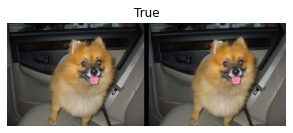

In [12]:
#Check our class
img = PILImage.create(files[0])
s = SiameseImage(img, img, True)
s.show()

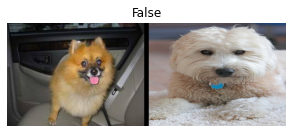

In [13]:
#Other scenario
img1 = PILImage.create(files[1])
s1 = SiameseImage(img, img1, False)
s1.show()

In [14]:
#Now we build our transform
def label_func(fname):
  return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

In [15]:
#We are going to apply different transforms on validation and training sets
class SiameseTransform(Transform):
  def __init__(self, files, label_func, splits):
    self.labels = files.map(label_func).unique()
    self.lbl2files = {l: L(f for f in files if label_func(f) == l)
                          for l in self.labels}
    self.label_func = label_func
    self.valid = {f: self._draw(f) for f in files[splits[1]]}

  def encodes(self, f):
    f2,t = self.valid.get(f, self._draw(f))
    img1, img2 = PILImage.create(f),PILImage.create(f2)
    return SiameseImage(img1, img2, t)
  
  def _draw(self, f):
    same = random.random() < .5
    cls = self.label_func(f)
    if not same:
      cls = random.choice(L(l for l in self.labels if l != cls))
    return random.choice(self.lbl2files[cls]), same

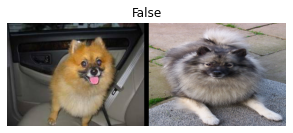

In [16]:
#Create main transform
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tfm(files[0]).show()

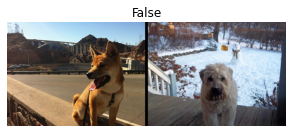

In [17]:
#use TfmdLists to apply on set of items
tls = TfmdLists(files, tfm, splits=splits)
show_at(tls.valid, 0)

In [18]:
#We can get our dataloaders from the class
dls = tls.dataloaders(
    after_item = [Resize(224), ToTensor], #apply transform once item is grabbed
    after_batch = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)] #Batch transform
)